## Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns  
from gensim.models import FastText
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Import and Subset Data

In [2]:
data = pd.read_csv("Data/GamesDataClean.csv", usecols=["content", "score", "game_name"])
data = data.dropna()
subset = (
    data.groupby("game_name", group_keys=False)
        .apply(lambda x: x.sample(n=min(50, len(x)), random_state=42))
        .reset_index(drop=True)
)
subset

C:\Users\Austin\AppData\Local\Temp\ipykernel_17616\3173297405.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(50, len(x)), random_state=42))


,game_name,content,score
0,8 Ball Pool,enjoy selection 8 ball video pool excite,5
1,8 Ball Pool,miniclip id miniclip account lose remember pas...,5
2,8 Ball Pool,graphic pair people extremely high level reall...,3
3,8 Ball Pool,thumb mediumlight skin tone web suck go line c...,1
4,8 Ball Pool,one ad make hang unresponsive annoy hope team ...,2
...,...,...,...
995,Shadow Fight 2,think need recharge energy ad fight make,3
996,Shadow Fight 2,need energy bar wait refill yhe person hoo mak...,1
997,Shadow Fight 2,think well compare l,5
998,Shadow Fight 2,love especially music sparkle heart,4


## Split X&Y, Train&Test

In [3]:
X = subset["content"].values
y = subset["score"].astype(int).values

In [4]:
tfidfContent = X

FastTextContent = []
for text in X:
    FastTextContent.append(text.split())

In [5]:
X_train_TF, X_test_TF, y_train_TF, y_test_TF = train_test_split(tfidfContent, y, test_size=0.2, random_state=42, stratify=y)
X_train_FT, X_test_FT, y_train_FT, y_test_FT = train_test_split(FastTextContent, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
if y_train_TF.min() == 1:
    y_train_TF = y_train_TF - 1
    y_test_TF  = y_test_TF  - 1
    y_train_FT = y_train_FT - 1
    y_test_FT  = y_test_FT  - 1

## TD-IDF Vectorizer

In [7]:
tfidf = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1,2),
    stop_words="english"
)
X_train_TF = tfidf.fit_transform(X_train_TF)
X_test_TF = tfidf.transform(X_test_TF)

## Fast Text

### For LogReg&XGB

In [8]:
model_ft = FastText(
    sentences=X_train_FT,
    vector_size=300,
    window=5,
    min_count=5,
    sg=1,
    workers=os.cpu_count(),
    epochs=10
)
ft = model_ft.wv

def avg_vector(tokens, model):
    words = [w for w in tokens if w in model.wv]
    if not words:
        return np.zeros(model.vector_size)
    return np.mean([model.wv[w] for w in words], axis=0)

X_train_avg = np.array([avg_vector(t, model_ft) for t in X_train_FT])
X_test_avg = np.array([avg_vector(t, model_ft) for t in X_test_FT])

### For BiLSTM

In [9]:
MAX_LEN   = 200
EMB_DIM   = 300
OOV_TOKEN = "<OOV>"

train_texts = [" ".join(toks) for toks in X_train_FT]
test_texts  = [" ".join(toks) for toks in X_test_FT]

tok = Tokenizer(oov_token=OOV_TOKEN)
tok.fit_on_texts(train_texts)
Xtr_ids = tok.texts_to_sequences(train_texts)
Xte_ids = tok.texts_to_sequences(test_texts)

Xtr_ids = pad_sequences(Xtr_ids, maxlen=MAX_LEN, padding="post", truncating="post")
Xte_ids = pad_sequences(Xte_ids, maxlen=MAX_LEN, padding="post", truncating="post")

vocab_size = len(tok.word_index) + 1
print("vocab_size:", vocab_size, "Xtr_ids:", Xtr_ids.shape)

vocab_size: 2850 Xtr_ids: (800, 200)


In [10]:
emb_matrix = np.zeros((vocab_size, EMB_DIM), dtype=np.float32)
for word, idx in tok.word_index.items():
    if word in model_ft.wv:
        emb_matrix[idx] = model_ft.wv[word]

## Logistic Regression

### TF-IDF + LogReg

In [11]:
lr_tfidf = LogisticRegression(
    max_iter=2000,
    multi_class="multinomial",
    class_weight="balanced",
    solver="lbfgs",
    n_jobs=-1
)
lr_tfidf.fit(X_train_TF, y_train_TF)
pred_TF_LR = lr_tfidf.predict(X_test_TF)

c:\Users\Austin\anaconda3\envs\TF\lib\site-packages\sklearn\linear_model\_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


### FastText + LogReg

In [12]:
lr_ft = LogisticRegression(
    max_iter=2000,
    multi_class="multinomial",
    class_weight="balanced",
    solver="lbfgs",
    n_jobs=-1
)
lr_ft.fit(X_train_avg, y_train_FT)
pred_FT_LR = lr_ft.predict(X_test_avg)

c:\Users\Austin\anaconda3\envs\TF\lib\site-packages\sklearn\linear_model\_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


FastText data is not made for Logistic Regression, therefore the performance will be bad 

## XGBoost Model

### TF-IDF + XGBoost

In [13]:
xgb_tfidf = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=len(np.unique(y_train_TF)),
    eval_metric="mlogloss",
    n_estimators=300,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",
    n_jobs=-1,
    random_state=42
)

xgb_tfidf.fit(X_train_TF, y_train_TF)
pred_TF_XGB = xgb_tfidf.predict(X_test_TF)

### FastText + XGBoost

In [14]:
xgb_ft = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=len(np.unique(y_train_FT)),
    eval_metric="mlogloss",
    n_estimators=300,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.8,
    tree_method="hist",
    n_jobs=-1,
    random_state=42
)

xgb_ft.fit(X_train_avg, y_train_FT)
pred_FT_XGB = xgb_ft.predict(X_test_avg)

## Bidirectional LSTM

### TF-IDF + BiLSTM

TF-IDF data cannot be used on LSTM

### FastText + BiLSTM

In [15]:
inp = layers.Input(shape=(MAX_LEN,), dtype="int32")
emb = layers.Embedding(
    input_dim=vocab_size,
    output_dim=EMB_DIM,
    weights=[emb_matrix],
    trainable=False,
    mask_zero=True
)(inp)

x = layers.SpatialDropout1D(0.3)(emb)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.4)(x)
out = layers.Dense(5, activation="softmax")(x)

FT_model = models.Model(inp, out)
FT_model.compile(
    optimizer=optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
FT_model.summary()

cbs = [
    callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5)
]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 300)          855000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 300)         0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 200, 256)         439296    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                             

In [16]:
ytr = np.asarray(y_train_FT)
yte = np.asarray(y_test_FT)

history = FT_model.fit(
    Xtr_ids, ytr,
    validation_split=0.1,
    epochs=25,
    batch_size=256,
    callbacks=cbs,
    verbose=1
)

proba = FT_model.predict(Xte_ids, batch_size=256, verbose=0)
pred_FT_LSTM  = proba.argmax(axis=1)

Epoch 1/25
3/3 [==============================] - 9s 692ms/step - loss: 1.5688 - accuracy: 0.3764 - val_loss: 1.5000 - val_accuracy: 0.4125 - lr: 0.0010
Epoch 2/25
3/3 [==============================] - 0s 45ms/step - loss: 1.5198 - accuracy: 0.4194 - val_loss: 1.4650 - val_accuracy: 0.4125 - lr: 0.0010
Epoch 3/25
3/3 [==============================] - 0s 48ms/step - loss: 1.4915 - accuracy: 0.4208 - val_loss: 1.4416 - val_accuracy: 0.4125 - lr: 0.0010
Epoch 4/25
3/3 [==============================] - 0s 40ms/step - loss: 1.4792 - accuracy: 0.4042 - val_loss: 1.4358 - val_accuracy: 0.4125 - lr: 0.0010
Epoch 5/25
3/3 [==============================] - 0s 41ms/step - loss: 1.4628 - accuracy: 0.4319 - val_loss: 1.4279 - val_accuracy: 0.4125 - lr: 0.0010
Epoch 6/25
3/3 [==============================] - 0s 41ms/step - loss: 1.4575 - accuracy: 0.4167 - val_loss: 1.4121 - val_accuracy: 0.4125 - lr: 0.0010
Epoch 7/25
3/3 [==============================] - 0s 38ms/step - loss: 1.4504 - accurac

## Model Evaluation

In [17]:
results = {
    "Text Rep": [
        "TF-IDF",
        "TF-IDF",
        "FastText (avg)",
        "FastText (avg)",
        "FastText (seq)"
    ],
    "Model": [
        "Logistic Regression",
        "XGBoost",
        "Logistic Regression",
        "XGBoost",
        "BiLSTM"
    ],
    "Accuracy": [
        accuracy_score(y_test_TF, pred_TF_LR),
        accuracy_score(y_test_TF, pred_TF_XGB),
        accuracy_score(y_test_FT, pred_FT_LR),
        accuracy_score(y_test_FT, pred_FT_XGB),
        accuracy_score(y_test_FT, pred_FT_LSTM)
    ],
    "Macro-F1": [
        f1_score(y_test_TF, pred_TF_LR, average="macro"),
        f1_score(y_test_TF, pred_TF_XGB, average="macro"),
        f1_score(y_test_FT, pred_FT_LR, average="macro"),
        f1_score(y_test_FT, pred_FT_XGB, average="macro"),
        f1_score(y_test_FT, pred_FT_LSTM, average="macro")
    ],
    "Weighted-F1": [
        f1_score(y_test_TF, pred_TF_LR, average="weighted"),
        f1_score(y_test_TF, pred_TF_XGB, average="weighted"),
        f1_score(y_test_FT, pred_FT_LR, average="weighted"),
        f1_score(y_test_FT, pred_FT_XGB, average="weighted"),
        f1_score(y_test_FT, pred_FT_LSTM, average="weighted")
    ]
}

df_results = pd.DataFrame(results)
df_results.round(4)

,Text Rep,Model,Accuracy,Macro-F1,Weighted-F1
0,TF-IDF,Logistic Regression,0.475,0.3214,0.4632
1,TF-IDF,XGBoost,0.505,0.2980,0.4540
2,FastText (avg),Logistic Regression,0.240,0.1911,0.2687
3,FastText (avg),XGBoost,0.445,0.2641,0.3987
4,FastText (seq),BiLSTM,0.450,0.2102,0.3662


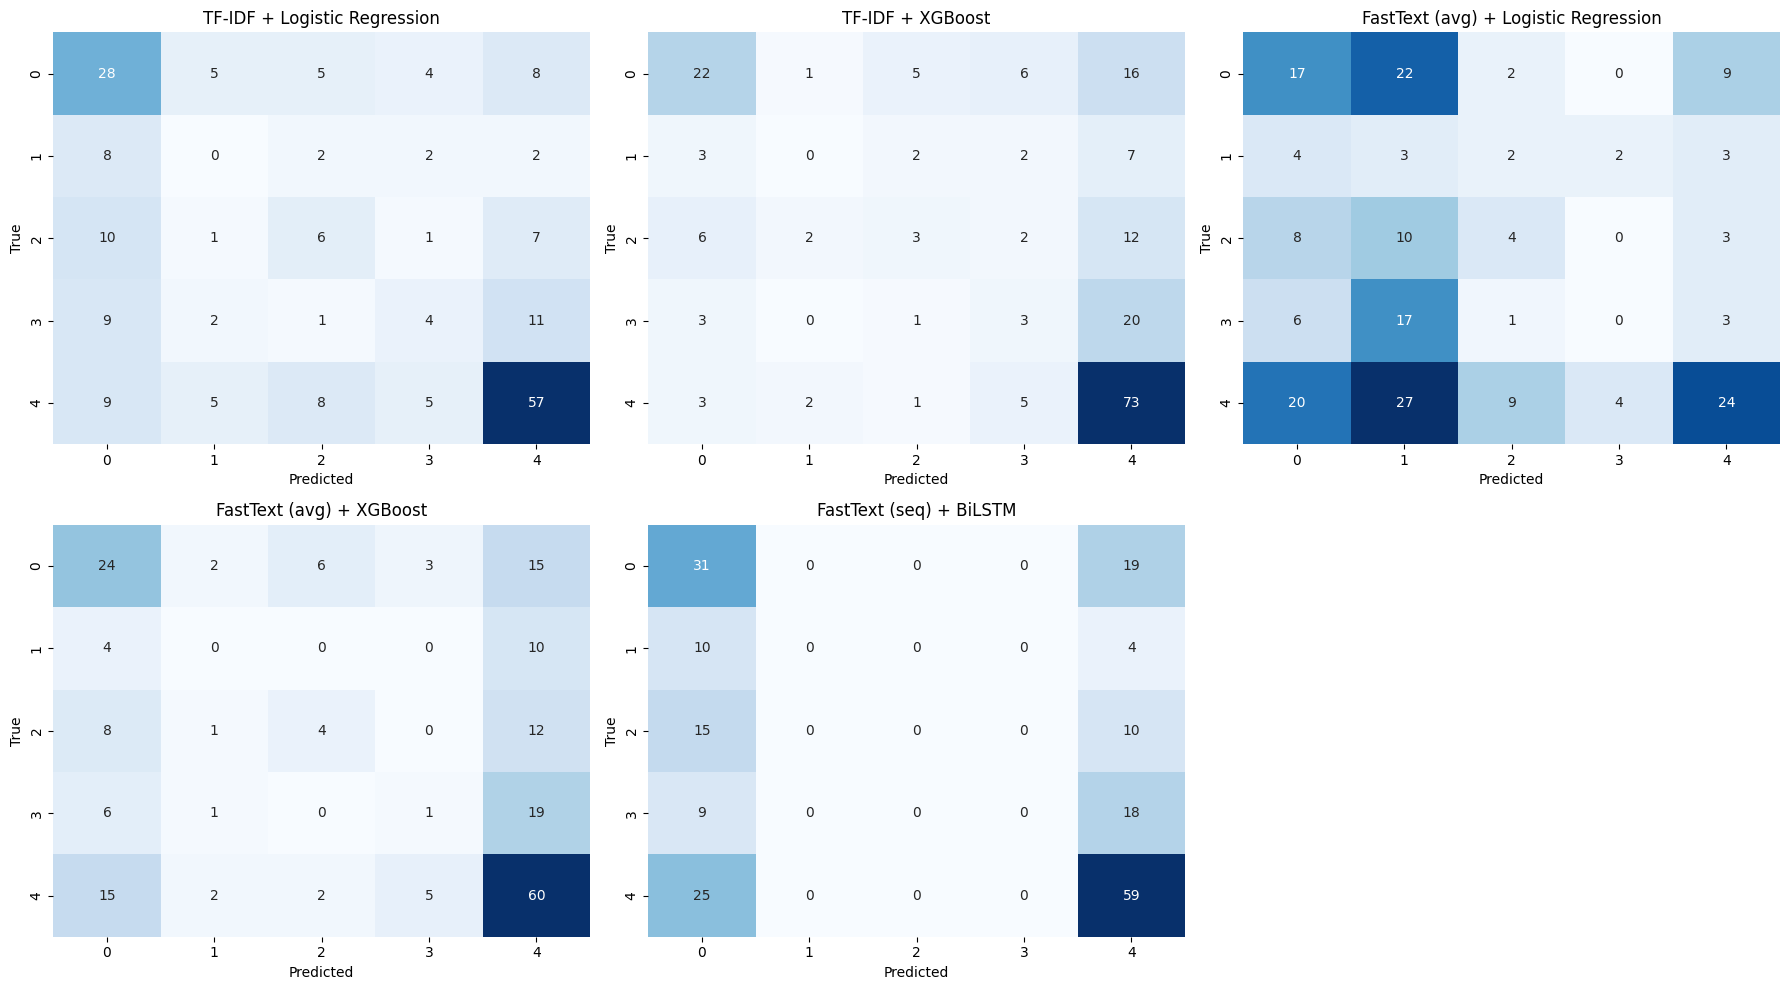

In [18]:
# --- Confusion Matrices ---
preds = [
    (pred_TF_LR, y_test_TF, "TF-IDF + Logistic Regression"),
    (pred_TF_XGB, y_test_TF, "TF-IDF + XGBoost"),
    (pred_FT_LR, y_test_FT, "FastText (avg) + Logistic Regression"),
    (pred_FT_XGB, y_test_FT, "FastText (avg) + XGBoost"),
    (pred_FT_LSTM, y_test_FT, "FastText (seq) + BiLSTM"),
]

num_classes = len(np.unique(y_test_TF))
class_labels = [str(i) for i in range(num_classes)]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, (pred, y_true, title) in enumerate(preds):
    if i >= len(axes):  # safety check if fewer than 6 subplots
        break
    cm = confusion_matrix(y_true, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_labels, yticklabels=class_labels, ax=axes[i])
    axes[i].set_title(title)
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("True")

# Hide extra subplot if any
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()